# Problem Formulation

1. The dataset contains concrete images having cracks. The task at hand is to classify if a image is negative or positive in terms of having cracks.

2. The dataset is divided into two classes, Negative and Positive crack images.
It must be divided evenly into train, validation and test batches. The Negative and Positive images also need to be shuffled together into a single batch.

3. Each class has 20000 images with 227 x 227 pixels with RGB channels.
These images must be resized to fit the maximum of 224 x 224 pixels required by MobileNetV2.

4. No data augmentation in terms of random rotation or flipping is applied.
It will be applied later with an augmentation layer.

5. Apply Transfer learning with MobileNetV2 then do fine-tuning.

# Data Preparation

In [ ]:
# import libraries
import splitfolders,os,random,cv2,datetime

import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt
from pyunpack import Archive

from tensorflow import keras
from tensorflow.keras import layers,optimizers,losses,metrics,callbacks,applications
from tensorflow.keras.utils import plot_model

In [ ]:
# extract zip file downloaded from reference [1]
!mkdir raw
RAW_PATH = os.path.join(os.getcwd(),'raw')
RAR_PATH = os.path.join(os.getcwd(),'Concrete Crack Images for Classification.rar')
Archive(RAR_PATH).extractall(RAW_PATH)

# split negative and positive folders to train, test, split
splitfolders.ratio(RAW_PATH, output="dataset", seed=1337, ratio=(.7, 0.2,0.1))
DATA_PATH = os.path.join(os.getcwd(),'dataset')

# define paths
train_path = DATA_PATH+'/train'
val_path = DATA_PATH+'/val'
test_path = DATA_PATH+'/test'

# constants
BATCH_SIZE = 32
IMG_SIZE = (224,224)
SEED = 123

# resize and shuffle
train_dataset = keras.utils.image_dataset_from_directory(train_path,shuffle=True,batch_size=BATCH_SIZE,image_size=IMG_SIZE,seed=None)
validation_dataset = keras.utils.image_dataset_from_directory(val_path,shuffle=True,batch_size=BATCH_SIZE,image_size=IMG_SIZE,seed=None)
test_dataset = keras.utils.image_dataset_from_directory(test_path,shuffle=True,batch_size=BATCH_SIZE,image_size=IMG_SIZE,seed=None)

# review some images from train dataset
class_names = train_dataset.class_names

plt.figure(figsize=(20,10))
for images,labels in train_dataset.take(1):
    for i in range(9):
        plt.subplot(3,3,i+1)
        plt.imshow(images[i].numpy().astype('uint8'))
        plt.title(class_names[labels[i]])
        plt.axis('off')

# Convert the BatchDataset into PrefetchDataset
AUTOTUNE = tf.data.AUTOTUNE

pf_train = train_dataset.prefetch(buffer_size=AUTOTUNE)
pf_val = validation_dataset.prefetch(buffer_size=AUTOTUNE)
pf_test = test_dataset.prefetch(buffer_size=AUTOTUNE)

print('Number of train batches: %d' % tf.data.experimental.cardinality(train_dataset))
print('Number of validation batches: %d' % tf.data.experimental.cardinality(validation_dataset))
print('Number of test batches: %d' % tf.data.experimental.cardinality(test_dataset))

# Create a small pipeline for data augmentation
data_augmentation = keras.Sequential()
data_augmentation.add(layers.RandomFlip('horizontal',seed=SEED))
data_augmentation.add(layers.RandomRotation(0.2,seed=SEED))

# Model Development

In [ ]:
# Prepare the layer for data preprocessing
preprocess_input = applications.mobilenet_v2.preprocess_input

# Apply transfer learning
IMG_SHAPE = (224,224,3)
feature_extractor = applications.MobileNetV2(input_shape=IMG_SHAPE,include_top=False,weights='imagenet')

# Disable the training for the feature extractor (freeze the layers)
feature_extractor.trainable = False
feature_extractor.summary()
keras.utils.plot_model(feature_extractor,show_shapes=True)

# Create the classification layers
global_avg = layers.GlobalAveragePooling2D()
l2 = keras.regularizers.L2()
output_layer = layers.Dense(len(class_names),activation='softmax',kernel_regularizer=l2)

# Use functional API to link all of the modules together
inputs = keras.Input(shape=IMG_SHAPE)
x = data_augmentation(inputs)
x = preprocess_input(x)
x = feature_extractor(x, training=False)
x = global_avg(x)
x = layers.Dense(300, activation=tf.keras.activations.relu)(x)
x = layers.Dropout(0.3)(x)
outputs = output_layer(x)
model = keras.Model(inputs=inputs,outputs=outputs)
model.summary()

# initial evaluation
loss0, accuracy0 = model.evaluate(validation_dataset)
print("initial loss: {:.2f}".format(loss0))
print("initial accuracy: {:.2f}".format(accuracy0))

# Compile the model
optimizer = optimizers.Adam(learning_rate=0.0001)
loss = losses.SparseCategoricalCrossentropy()
model.compile(optimizer=optimizer,loss=loss,metrics=['accuracy'])

# specify callbacks
log_path = os.path.join('log_dir',datetime.datetime.now().strftime('%Y%m%d-%H%M%S'))
tb = callbacks.TensorBoard(log_dir=log_path)

# Train the model
EPOCHS = 1
history = model.fit(pf_train,validation_data=pf_val,epochs=EPOCHS,callbacks=[tb])

Model: "model_7"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_13 (InputLayer)       [(None, 224, 224, 3)]     0         
                                                                 
 sequential (Sequential)     (None, 224, 224, 3)       0         
                                                                 
 tf.math.truediv_10 (TFOpLam  (None, 224, 224, 3)      0         
 bda)                                                            
                                                                 
 tf.math.subtract_10 (TFOpLa  (None, 224, 224, 3)      0         
 mbda)                                                           
                                                                 
 mobilenetv2_1.00_224 (Funct  (None, 7, 7, 1280)       2257984   
 ional)                                                          
                                                           

In [ ]:
# unfreeze all layers and freeze only early layers
feature_extractor.trainable = True
for layer in feature_extractor.layers[:100]:
    layer.trainable = False

# compile the model
optimizer = optimizers.RMSprop(learning_rate=0.00001)
model.compile(optimizer=optimizer,loss=loss,metrics=['accuracy'])

fine_tune_epoch = 5
history_fine = model.fit(pf_train,validation_data=pf_val,epochs=fine_tune_epoch,initial_epoch=history.epoch[-1],callbacks=[tb])

Epoch 1/6
875/875 [==============================] - 159s 176ms/step - loss: 0.0295 - accuracy: 0.9985 - val_loss: 0.0269 - val_accuracy: 0.9990
Epoch 2/6
875/875 [==============================] - 100s 114ms/step - loss: 0.0251 - accuracy: 0.9990 - val_loss: 0.0235 - val_accuracy: 0.9990
Epoch 3/6
875/875 [==============================] - 100s 114ms/step - loss: 0.0213 - accuracy: 0.9991 - val_loss: 0.0196 - val_accuracy: 0.9990
Epoch 4/6
875/875 [==============================] - 102s 116ms/step - loss: 0.0178 - accuracy: 0.9992 - val_loss: 0.0177 - val_accuracy: 0.9991
Epoch 5/6
875/875 [==============================] - 101s 115ms/step - loss: 0.0163 - accuracy: 0.9990 - val_loss: 0.0155 - val_accuracy: 0.9991
Epoch 6/6
875/875 [==============================] - 100s 114ms/step - loss: 0.0132 - accuracy: 0.9991 - val_loss: 0.0132 - val_accuracy: 0.9991


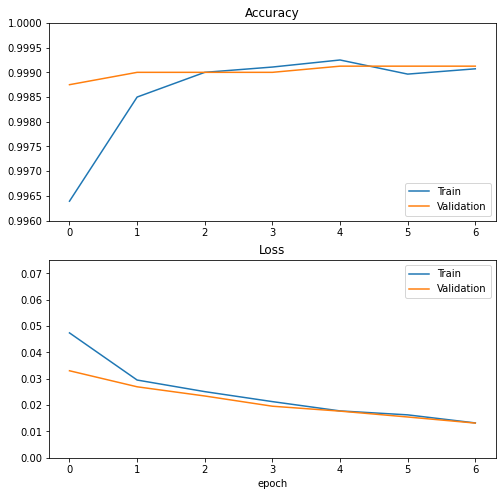

In [ ]:
# plot performance of model and save image
acc = history.history['accuracy'] + history_fine.history['accuracy']
val_acc = history.history['val_accuracy'] + history_fine.history['val_accuracy']

loss = history.history['loss'] + history_fine.history['loss']
val_loss = history.history['val_loss'] + history_fine.history['val_loss']

plt.figure(figsize=(8, 8))
plt.subplot(2, 1, 1)
plt.plot(acc, label='Train')
plt.plot(val_acc, label='Validation')
plt.ylim([0.996, 1])
plt.legend(loc='lower right')
plt.title('Accuracy')

plt.subplot(2, 1, 2)
plt.plot(loss, label='Train')
plt.plot(val_loss, label='Validation')
plt.ylim([0, 0.075])
plt.legend(loc='upper right')
plt.title('Loss')
plt.xlabel('epoch')
plt.savefig('Performance.png')
plt.show()

# plot model architecture and save image
plot_model(model, show_shapes=True, show_layer_names=True)

# save model
model.save('model.h5')

# Model Deployment

125/125 [==============================] - 8s 58ms/step - loss: 0.0121 - accuracy: 0.9992
Loss =  0.012081422843039036
Accuracy =  0.9992499947547913
1/1 [==============================] - 1s 731ms/step


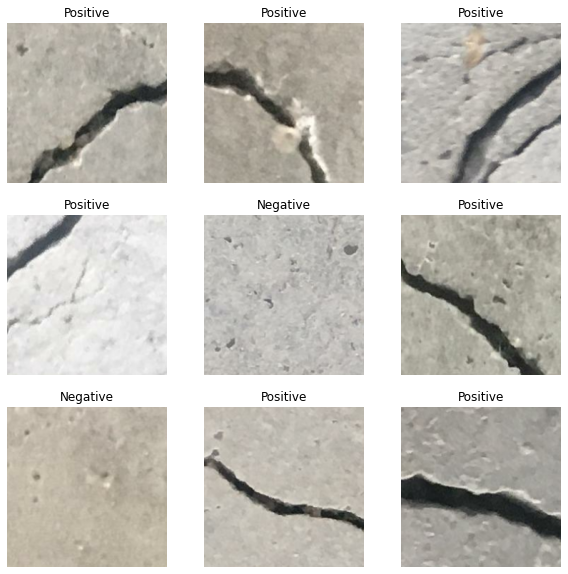

In [ ]:
# Evaluate the final model
test_loss,test_acc = model.evaluate(pf_test)

print("Loss = ",test_loss)
print("Accuracy = ",test_acc)

# Deploy the model using the test data
image_batch, label_batch = pf_test.as_numpy_iterator().next()
predictions = np.argmax(model.predict(image_batch),axis=1)

# Compare label and prediction
print('Predictions:\n', predictions)
print('Labels:\n', label_batch)

plt.figure(figsize=(10, 10))
for i in range(9):
  ax = plt.subplot(3, 3, i + 1)
  plt.imshow(image_batch[i].astype("uint8"))
  plt.title(class_names[predictions[i]])
  plt.axis("off")